# Task 3 — Time Series Forecasting (Hourly Energy)
Synthetic hourly energy with daily + weekly seasonality. We explore seasonality, split train/test, build a lag-based model, and compare to a naive baseline.

In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import sqrt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge

idx = pd.date_range("2023-01-01", periods=24*150, freq="H")  # 150 days
rng = np.random.default_rng(7)
daily = 2*np.sin(2*np.pi*idx.hour/24)
weekly = 1*np.sin(2*np.pi*idx.dayofweek/7)
trend = np.linspace(0, 3, len(idx))
noise = rng.normal(0, 0.5, len(idx))
y = 5 + daily + weekly + 0.02*trend + noise
s = pd.Series(y, index=idx, name="kW")
s.head()


2023-01-01 00:00:00    4.218784
2023-01-01 01:00:00    4.885196
2023-01-01 02:00:00    5.081133
2023-01-01 03:00:00    5.187136
2023-01-01 04:00:00    5.722951
Freq: H, Name: kW, dtype: float64

### 1) Full series
Line chart to see overall pattern.

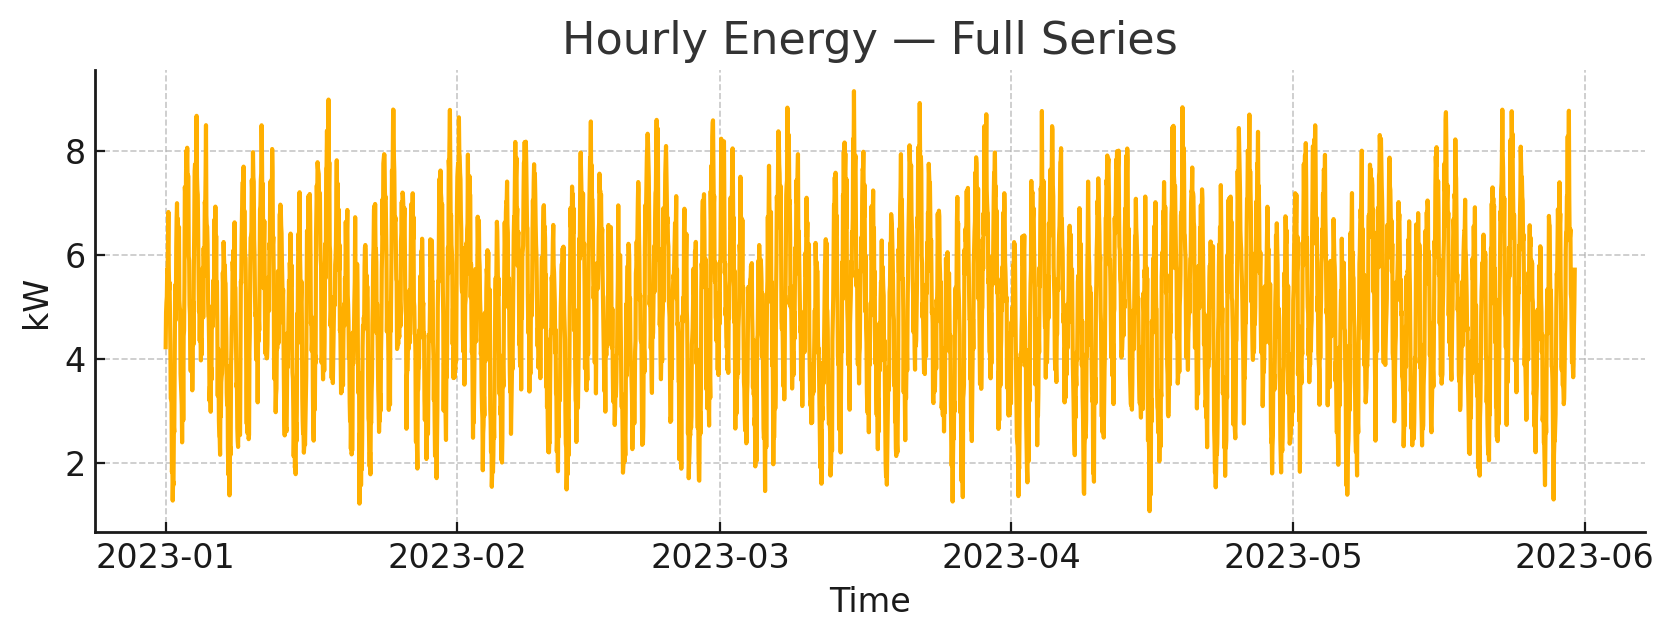

In [2]:

plt.figure(figsize=(10,3)); plt.plot(s.index, s.values)
plt.title("Hourly Energy — Full Series"); plt.xlabel("Time"); plt.ylabel("kW"); plt.show()


### 2) Seasonal patterns (by hour & by weekday)
Averages reveal strong daily/weekly cycles.

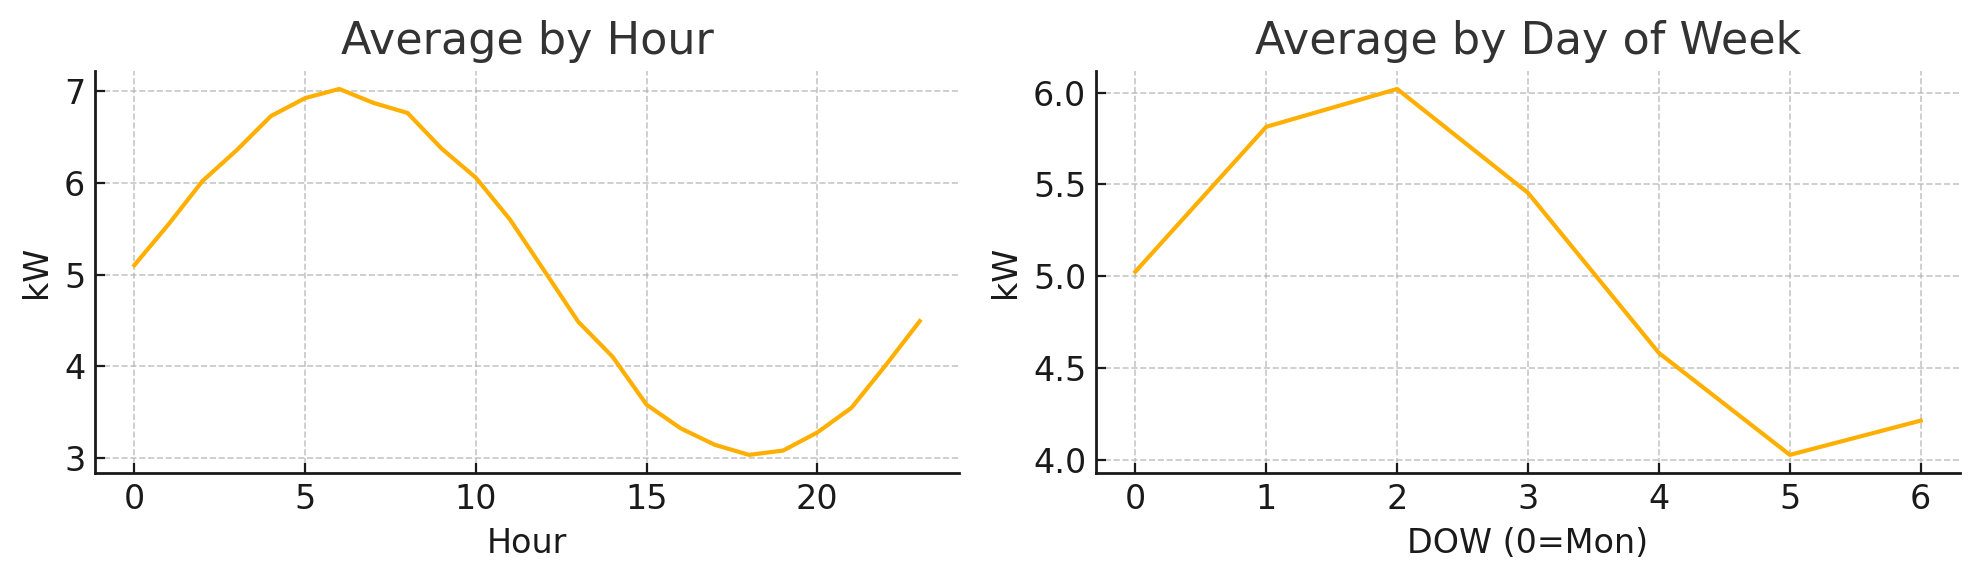

In [3]:

by_hour = s.groupby(s.index.hour).mean()
by_dow  = s.groupby(s.index.dayofweek).mean()

fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(by_hour.index, by_hour.values); ax[0].set_title("Average by Hour")
ax[0].set_xlabel("Hour"); ax[0].set_ylabel("kW")

ax[1].plot(by_dow.index, by_dow.values); ax[1].set_title("Average by Day of Week")
ax[1].set_xlabel("DOW (0=Mon)"); ax[1].set_ylabel("kW")
plt.tight_layout(); plt.show()


### 3) Train/Test split and rolling stats
We visualize split and rolling mean/variance.

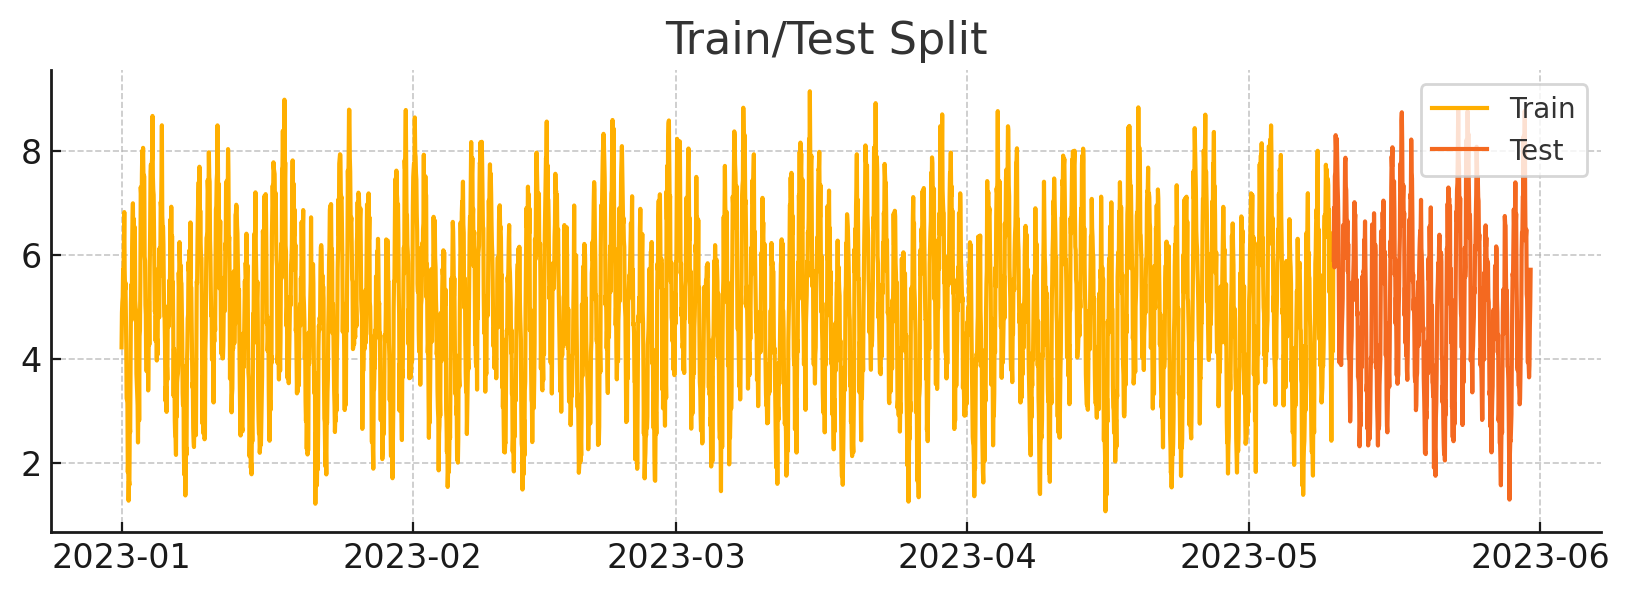

In [4]:

split = s.index[-24*21]  # last 21 days test
train, test = s[:split], s[split:]

plt.figure(figsize=(10,3)); plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test")
plt.legend(); plt.title("Train/Test Split"); plt.show()


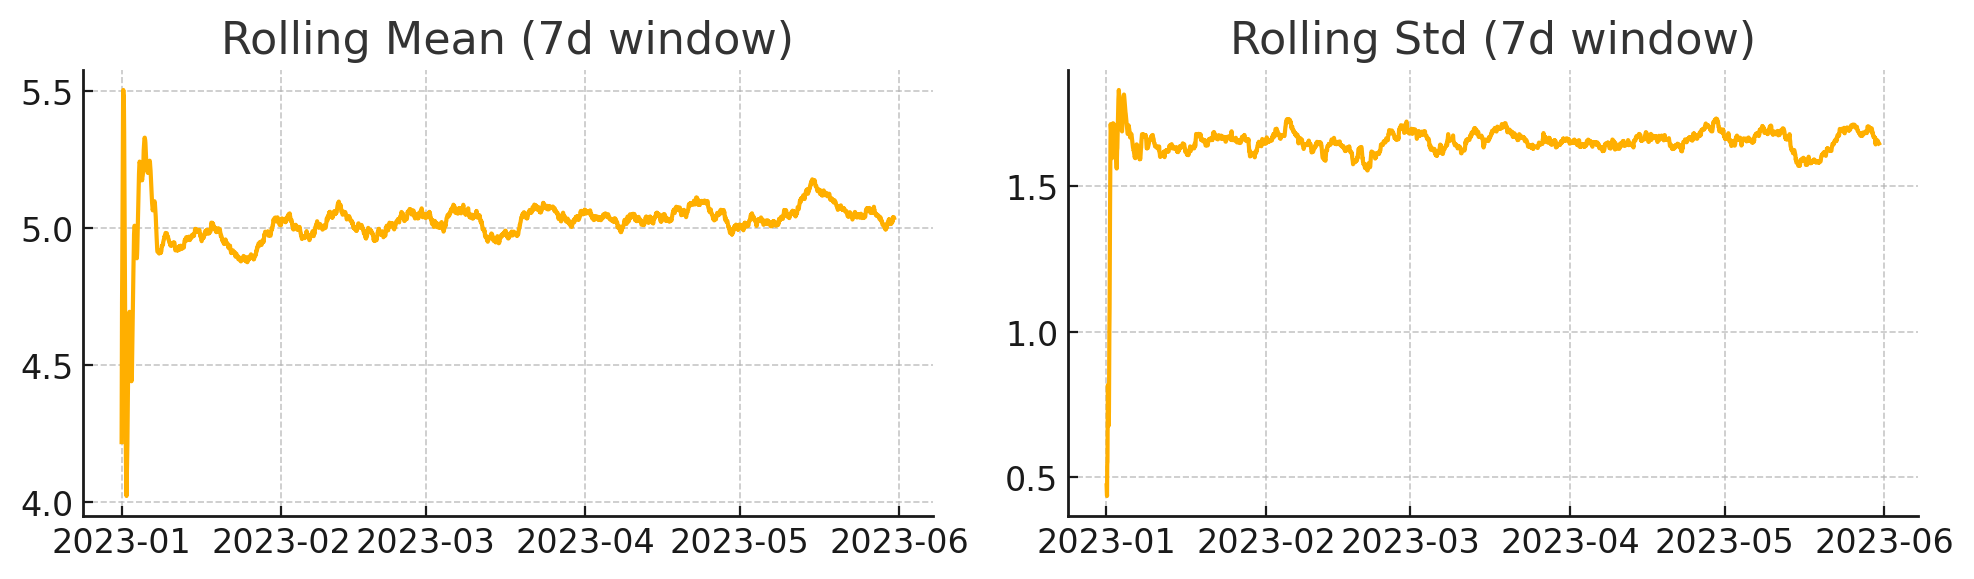

In [5]:

roll_mean = s.rolling(24*7, min_periods=1).mean()
roll_std  = s.rolling(24*7, min_periods=1).std()
rm = roll_mean.dropna()
rs = roll_std.dropna()
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(rm.index, rm.values); ax[0].set_title("Rolling Mean (7d window)")
ax[1].plot(rs.index, rs.values); ax[1].set_title("Rolling Std (7d window)")
plt.tight_layout(); plt.show()


### 4) Baseline vs Model
Naive(t-24) vs Ridge on lag features + calendar variables.

In [6]:

# Baseline
naive = s.shift(24).loc[test.index].dropna()
align = test.loc[naive.index]
mae_naive = mean_absolute_error(align, naive)
rmse_naive = sqrt(mean_squared_error(align, naive))

# Lag-based model
def make_features(series):
    df = pd.DataFrame({"y": series})
    for lag in [1,2,24,24*7]:
        df[f"lag_{lag}"] = df["y"].shift(lag)
    df["hour"] = df.index.hour
    df["dow"] = df.index.dayofweek
    return df.dropna()

feat_train = make_features(train)
Xtr = feat_train.drop(columns=["y"]); ytr = feat_train["y"]
model = Ridge(alpha=1.0).fit(Xtr, ytr)

feat_test = make_features(pd.concat([train, test]))
feat_test = feat_test.loc[test.index].dropna()
Xte = feat_test.drop(columns=["y"]); yte = s.loc[Xte.index]
pred = model.predict(Xte)

mae = mean_absolute_error(yte, pred); rmse = sqrt(mean_squared_error(yte, pred))
print({"MAE_naive": round(mae_naive,3), "RMSE_naive": round(rmse_naive,3),
       "MAE_model": round(mae,3), "RMSE_model": round(rmse,3)})


{'MAE_naive': 0.719, 'RMSE_naive': 0.875, 'MAE_model': 0.443, 'RMSE_model': 0.555}


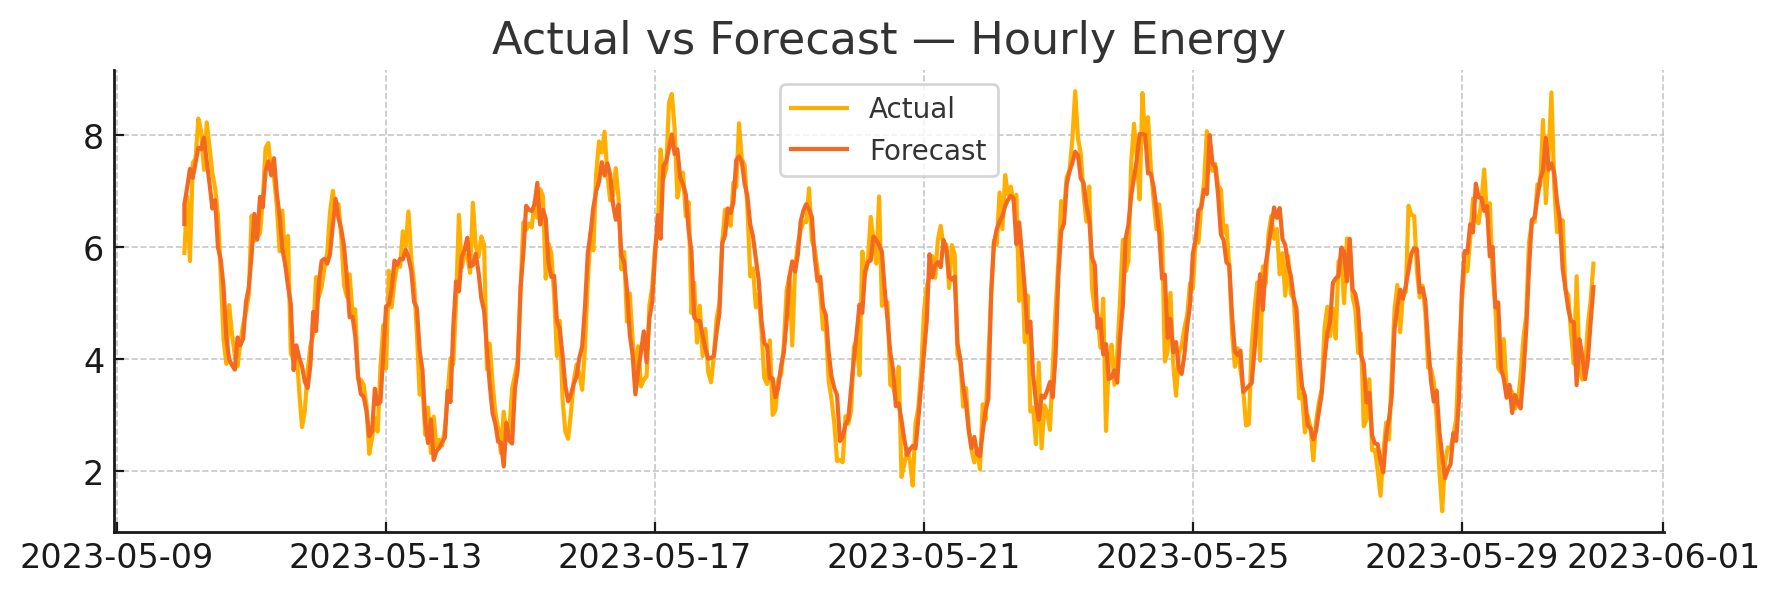

In [7]:

plt.figure(figsize=(10,3))
plt.plot(yte.index, yte.values, label="Actual")
plt.plot(yte.index, pred, label="Forecast")
plt.title("Actual vs Forecast — Hourly Energy"); plt.legend(); plt.show()


### 5) Error diagnostics
Distribution of errors (forecast - actual).

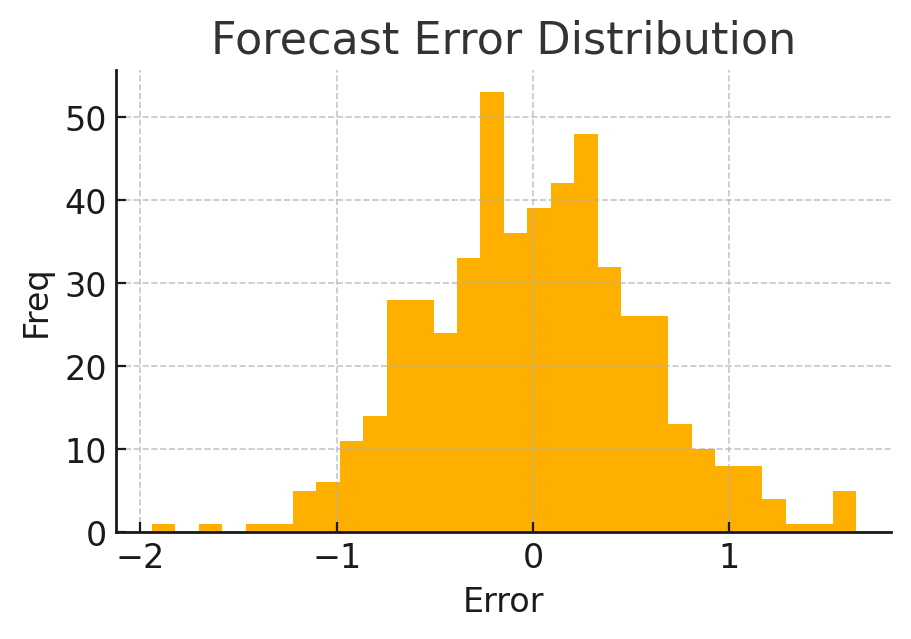

In [8]:

err = pred - yte.values
plt.figure(figsize=(5,3)); plt.hist(err, bins=30)
plt.title("Forecast Error Distribution"); plt.xlabel("Error"); plt.ylabel("Freq"); plt.show()
